# Data Preparation

- new variable unregistered (cnt - registered)

## 1 Setup

In [1]:
#import idstools
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
%matplotlib inline

## 2 Import der Daten

Um den Testdatensatz vorzubereiten, hier einfach `test` statt `train` einsetzen.

In [2]:
file_to_prepare = "train"

In [3]:
data = pd.read_csv(f"../data/BikeRentalDaily_{file_to_prepare}.csv", sep=";", index_col=0)

## 3 Minimal Preprocessing

**Create a baseline linear regression model using the originally provided training 
dataset with minimal preprocessing and evaluate it with your validation dataset based on accuracies (MAE) and coefficient of determination (𝑅²)**

Während unserer ersten Analysen in Task 1 ist uns aufgefallen, dass die Variablen `season` und `hum` fehlende Werte aufweisen. Als Default-Methode und im Sinne von Minimal Preprocessing sollen die Zeilen mit fehlenden Werten entfernt werden.
Optionale Methoden zum Umgang mit fehlenden Werten werden im weiteren Verlauf addressiert.

In [4]:
data = data.dropna()

## 4 Baseline Linear Regression Model

Die Summe von casual und registered ergibt cnt, daher entfernen wir diese Spalten aus dem Datensatz.

In [5]:
y_label = 'cnt'

features = data.drop(columns=[y_label, 'dteday', 'casual', 'registered']).columns

X = data[features]

y = data[y_label]

Erneuter Split des Trainingsdatensets, um ein Validation Datset zu generieren

In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [7]:
reg = LinearRegression()

In [8]:
reg.fit(X, y)

LinearRegression()

In [9]:
y_pred = reg.predict(X_validation)

In [10]:
r2 = r2_score(y_validation, y_pred).round(2)
mae = mean_absolute_error(y_validation, y_pred).round(2)

print(f'R2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

R2 Score: 0.22
Mean Absolute Error: 1338.16


In [11]:
for coef, feature in zip(reg.coef_, X.columns):
    print(feature, abs(round(coef, 2)))

season 429.28
yr 2602.73
mnth 6.63
holiday 804.99
weekday 219.27
workingday 656.42
weathersit 776.59
temp 11.42
atemp 7569.55
hum 6.33
windspeed 662.51
leaflets 1.19
price reduction 381.04


## 5 Other Options for Missing Value Handling

**Preprocess the original datasets to address the identified data quality issues e.g. Missing values, Outliers, Features to be transformed (e.g. normalization). Check the effect of each preprocessing step with your validation data set* building additional linear regression models**

Einfluss auf R2 und MAE prüfen

Hier jetzt zum Beispiel verschiedene Imputation Strategien

Wie wir bereits in Task 1 erarbeitet haben, weisen die Spalten `season` und `hum` fehlende Werte auf. Im ersten Schritt haben wir diese Zeilen entfernt. Nun wollen wir die fehlenden Werte imputieren.

In [12]:
data = pd.read_csv(f"../data/BikeRentalDaily_{file_to_prepare}.csv", sep=";", index_col=0)

<Axes: >

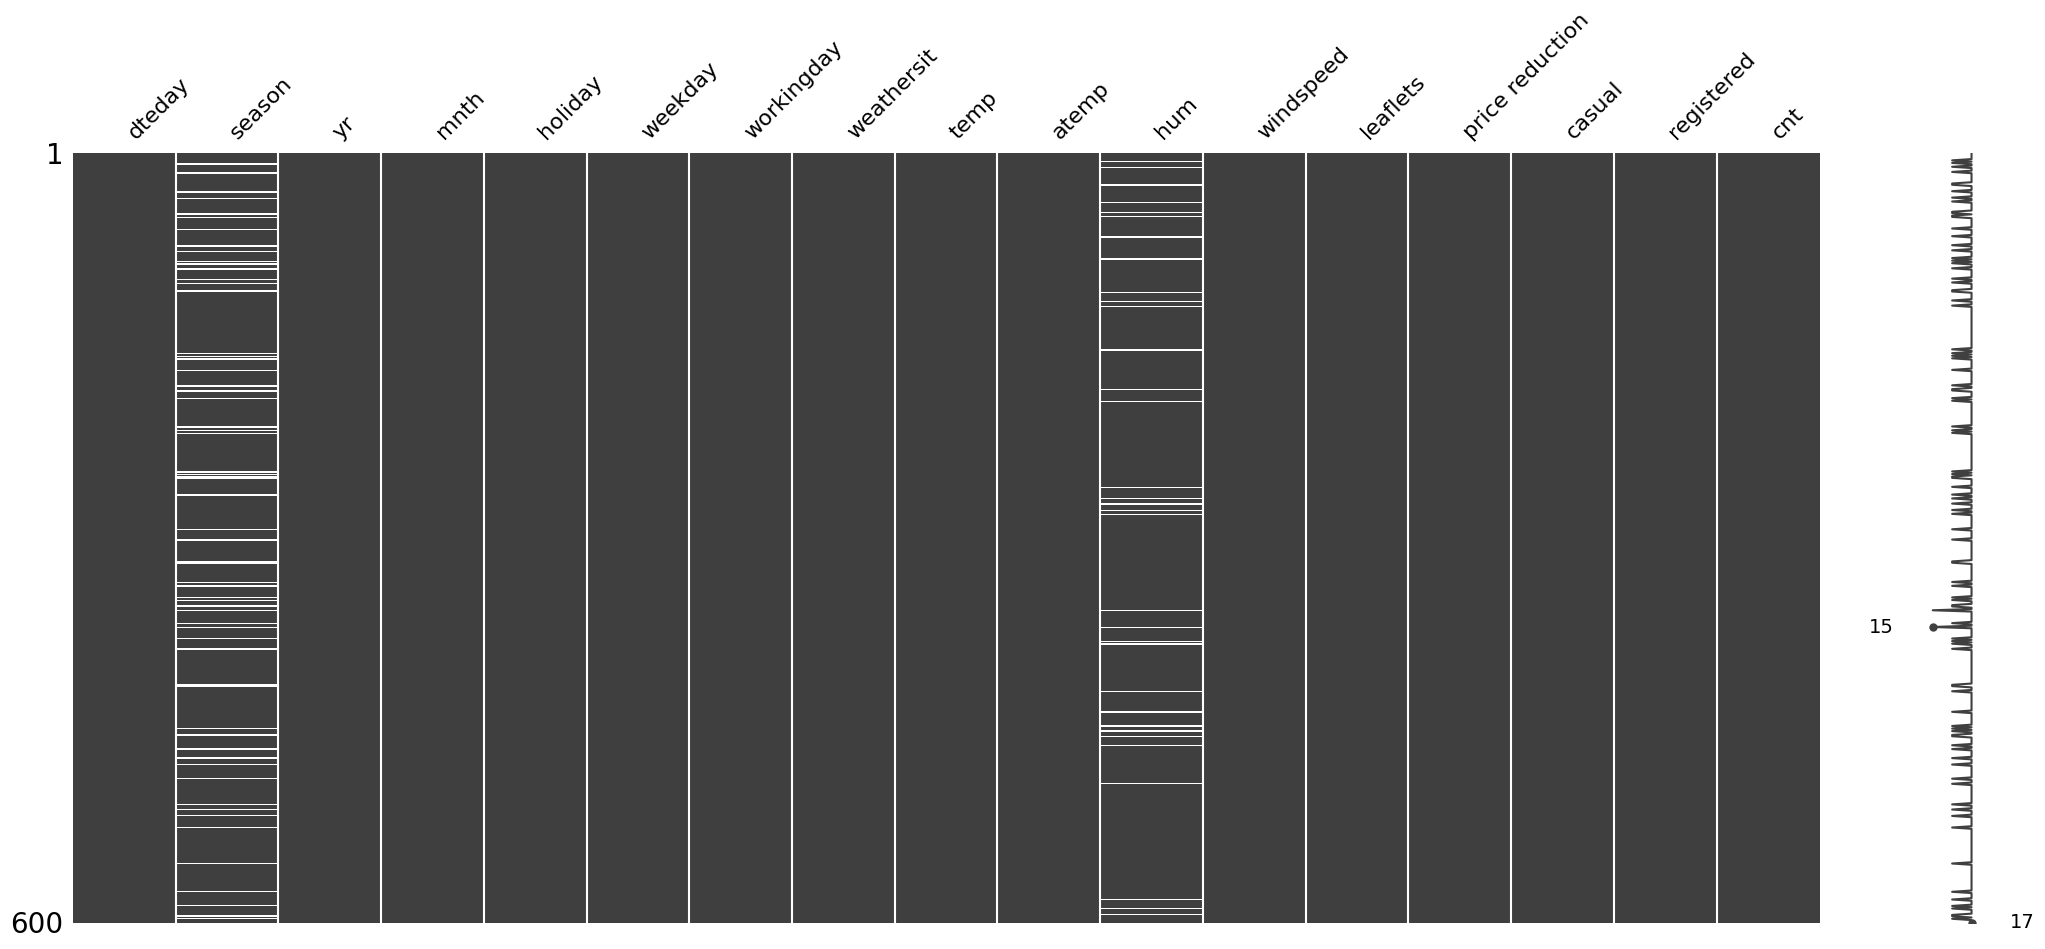

In [13]:
msno.matrix(data)

Die fehlenden Werte in der Spalte `season` werden anhand des vorliegenden Datums in der entsprechenden Zeile aufgefüllt. 

`get_season_by_date` bestimmt die Jahreszeit anhand eines Datums im Format "dd.mm". Sie verwendet das Modul time, um feste Zeitpunkte für den Beginn der Jahreszeiten (Frühling, Sommer, Herbst, Winter) festzulegen und vergleicht dann das eingegebene Datum mit diesen Zeitpunkten. Die Funktion gibt eine Ganzzahl zurück, die die entsprechende Jahreszeit repräsentiert (1 für Frühling, 2 für Sommer, 3 für Herbst, 4 für Winter). Beachte jedoch, dass die Funktion Schwierigkeiten mit dem 29. Februar haben könnte, wenn keine Jahreszahl angegeben ist, da sie die Schaltjahre nicht berücksichtigt.
Es gibt vier fest definierte Zeitpunkte für den Beginn jeder Jahreszeit (Frühling, Sommer, Herbst, Winter). Diese Zeitpunkte sind auf den 20. März, 20. Juni, 20. September und 20. Dezember festgelegt.

In [14]:
# datetime.datetime kann nicht mit 29. Feb umgehen, wenn keine Jahreszahl dabei ist
import time
def get_season_by_date(date: str):
    """Derive season by date"""
    dateformat = "%d.%m"

    # Season beginnings
    spring = time.strptime("20.03", dateformat)
    summer = time.strptime("20.06", dateformat)
    autumn = time.strptime("20.09", dateformat)
    winter = time.strptime("20.12", dateformat)

    date_p = time.strptime(date[:5], dateformat)

    if date_p < spring:
        return 1
    elif spring < date_p < summer:
        return 2
    elif summer < date_p < autumn:
        return 3
    elif autumn < date_p < winter:
        return 4
    else:
        return 1

In [15]:
def season_wrapper(row):
    row["season"] = get_season_by_date(row["dteday"])
    return row
data = data.apply(season_wrapper, axis=1)
data

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
154,03.06.2011,2,0,6,0,5,1,1,24.8000,0.587133,53.12505,0.253121,991,0,898,4414,5312
685,15.11.2012,4,1,11,0,4,1,2,12.8667,0.324492,93.06255,0.152987,601,0,320,5125,5445
368,03.01.2012,1,1,1,0,2,1,1,6.0000,0.126275,66.18750,0.365671,549,0,89,2147,2236
472,16.04.2012,2,1,4,1,1,0,1,26.5667,0.614925,84.25005,0.284829,740,0,1198,5172,6370
442,17.03.2012,1,1,3,0,-1,0,2,20.5667,0.505046,113.37495,0.110704,773,1,3155,4681,7836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,19.03.2011,1,0,3,0,6,0,1,18.9000,0.466525,56.87505,0.368167,1022,1,1424,1693,3117
81,22.03.2011,2,0,3,0,2,1,1,17.6667,0.440642,93.68745,0.225750,551,0,460,2243,2703
377,12.01.2012,1,1,1,0,4,1,2,15.3000,0.381938,120.43755,0.180967,520,0,269,3828,4097


Fehlende Werte in der Spalte `hum` werden durch den Mittelwert ersetzt. (Wir können über andere Ersetzungswerte noch diskutieren!)

In [16]:
data["hum"].fillna(np.mean(data["hum"]), inplace=True)

/tmp/ipykernel_199021/4199074127.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["hum"].fillna(np.mean(data["hum"]), inplace=True)


<Axes: >

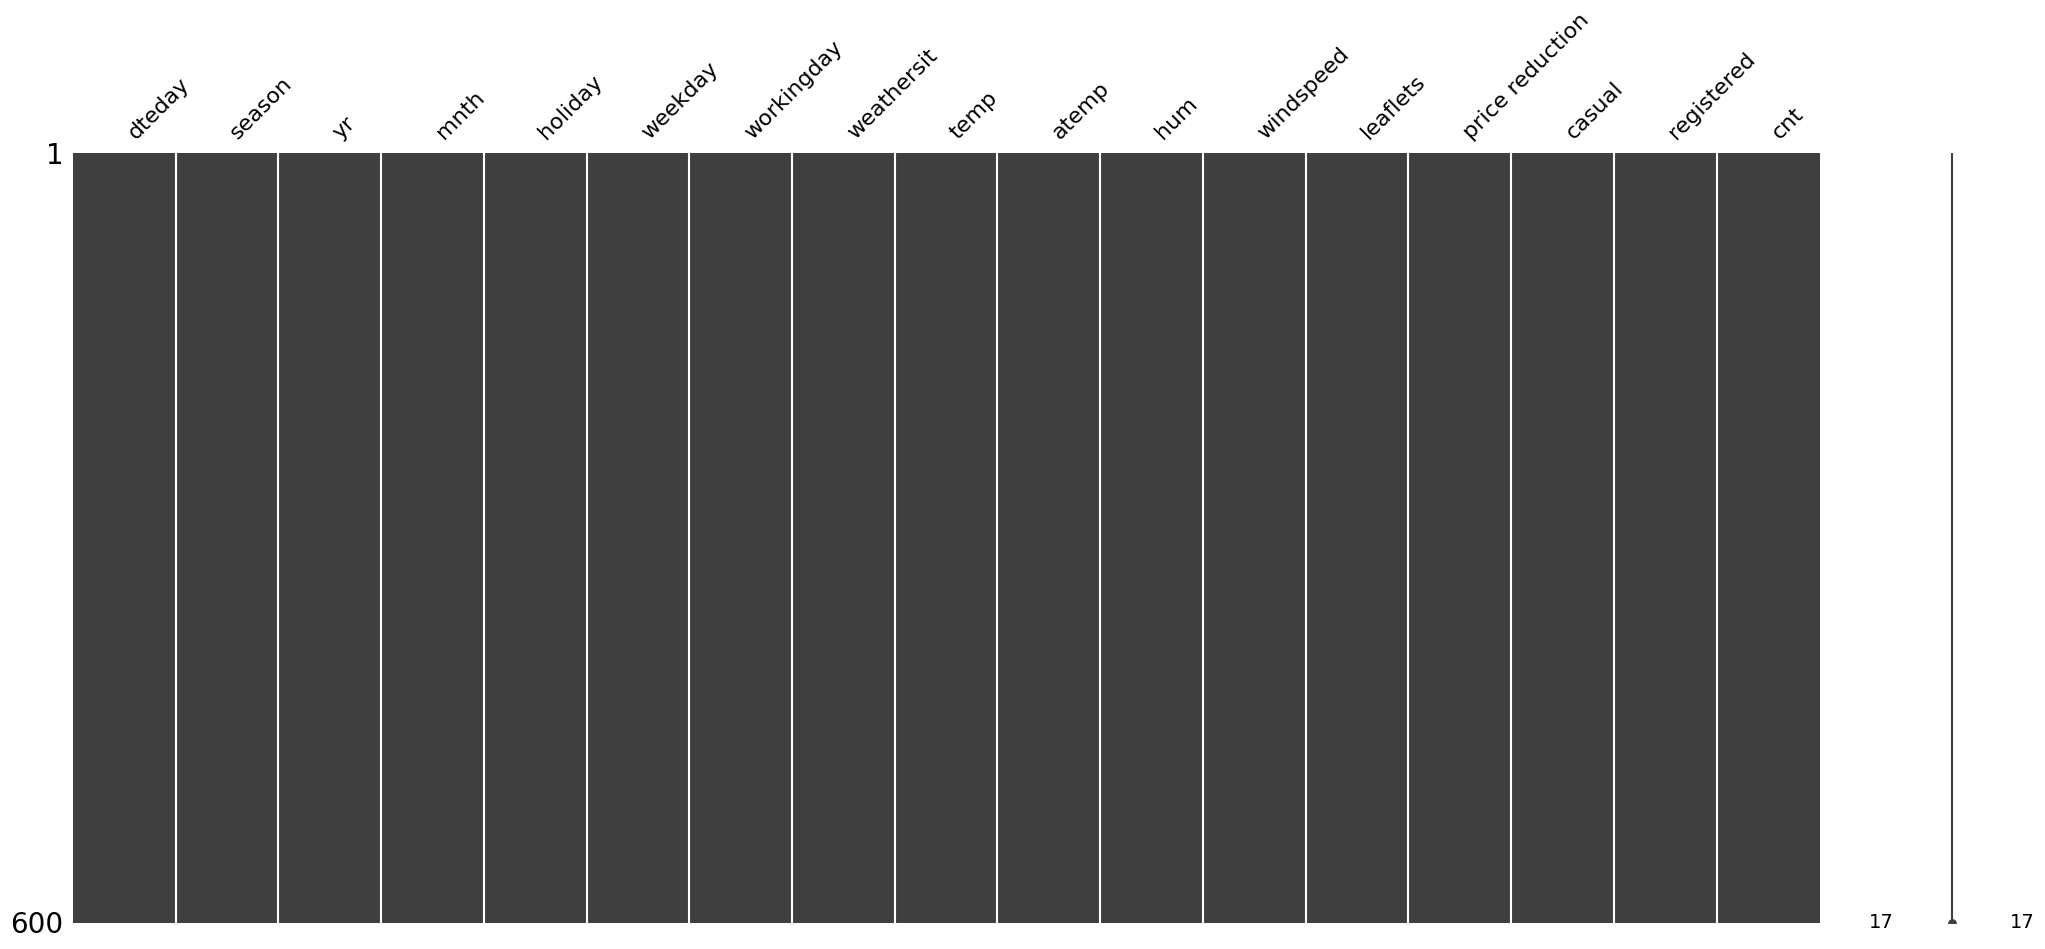

In [18]:
msno.matrix(data)

## 6 Data Corrections

Aus der deskriptiven Statistik ist ersichltich, dass das Minimum der Variable "windspeed" bei -1 liegt. Da die Windgeschwindigkeit nicht negativ sein kann, treffen wir die Annahme, dass es sich hierbei um Fehler handeln muss. Zunächst identifizieren wir hierfür die entsprechenden Zeilen.

In [19]:
negative_rows_windspeed = data[data['windspeed'] < 0].index

negative_rows_windspeed

Index([197, 155, 224, 236], dtype='int64', name='instant')

In [20]:
negative_rows = data.loc[data['windspeed'] < 0]

print(negative_rows)

             dteday  season  yr  mnth  holiday  weekday  workingday  \
instant                                                               
197      16.07.2011       3   0     7        0        6           0   
155      04.06.2011       2   0     6        0        6           0   
224      12.08.2011       3   0     8        0        5           1   
236      24.08.2011       3   0     8        0        3           1   

         weathersit     temp     atemp      hum  windspeed  leaflets  \
instant                                                                
197               1  27.4667  0.638263  87.7500       -1.0       731   
155               1  25.4000  0.594696  68.4375       -1.0       624   
224               1  28.3333  0.654042  62.2500       -1.0       835   
236               1  26.9333  0.630692  90.7500       -1.0       935   

         price reduction  casual  registered   cnt  
instant                                             
197                    0    2418  

Hier würde sich ggf. eine Regression Imputation zum Auffüllen der vier fehlenden Werte anbieten. Aus der Correlation Matrix sehen wir aber, dass windspeed kaum mit anderen Features correliert. Aus diesem Grund droppen wir die Werte.

Im Anschluss entfernen wir die entsprechenden vier Zeilen aus dem Dataframe.

In [21]:
data = data.drop(negative_rows_windspeed)

Der Wochentag `-1` ist offensichtlich ein fehlender Wert, der ebenfalls behoben werden muss.

In [22]:
def get_wday_by_date(row):
    if row["weekday"] > 0:
        return row
    weekday_shift = { # week starts on Sunday in dataset
        6: 0,
        0: 1,
        1: 2,
        2: 3,
        3: 4,
        4: 5,
        5: 6
    }
    dateformat = "%d.%m.%Y"
    row["weekday"] = weekday_shift[time.strptime(row["dteday"], dateformat).tm_wday]
    return row
data = data.apply(get_wday_by_date, axis=1)

## 7 Outlier Detection and Handling

Es ist zu sehen, dass die Gesamtanzahl und die Zahl der nicht registrierten Nutzer einen sehr hohen Maximalwert haben. Die Gesamtzahl wird aus registrierten Nutzern + nicht registrierten Nutzern hergeleitet -> Die Outlier werden mittels der `casual` Spalte ermittelt.

In [23]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,596.0,2.442953,1.122018,1.000000,1.000000,2.000000,3.000000,4.000000
yr,596.0,0.500000,0.500420,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,596.0,6.469799,3.453036,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,596.0,0.030201,0.171285,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,596.0,3.018456,2.002854,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,596.0,0.681208,0.466400,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,596.0,1.404362,0.543176,1.000000,1.000000,1.000000,2.000000,3.000000
temp,596.0,19.759794,7.206026,2.365200,13.491675,19.966650,26.000000,34.466700
atemp,596.0,0.472574,0.160457,0.079070,0.337891,0.487364,0.603868,0.826371
hum,596.0,93.956262,20.766061,28.187550,78.468712,93.845200,108.437550,145.875000


Aus dem Grund, dass cnt die Summe aus casual und registered ist, wird beim entfernen der Outlier von casual auch die Outlier von cnt entfernt. Weil wir die row droppen. 

-> nur werte droppen?
-> hum wert anschauen

In [24]:
from scipy import stats
zscores = stats.zscore(data["casual"])
thresh = 3.0
outliers = data[abs(zscores) > thresh]
outliers

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
631,22.09.2012,4,1,9,0,6,0,1,26.0000,0.610488,97.00005,0.283583,963,0,47138,5883,53021
505,19.05.2012,2,1,5,0,6,0,1,24.0000,0.566908,68.43750,0.083975,1030,0,38061,4884,42945
448,23.03.2012,2,1,3,0,5,1,2,24.0667,0.570067,104.12505,0.116300,535,1,26150,5893,32043
624,15.09.2012,3,1,9,0,6,0,1,24.3333,0.585867,75.25005,0.247521,820,0,30378,5554,35932


Diese Werte werden entfernt

In [25]:
data_no_out = data.drop(outliers.index, errors="ignore")

In [26]:
data_no_out.describe().T

,count,mean,std,min,25%,50%,75%,max
season,592.0,2.440878,1.123455,1.000000,1.000000,2.000000,3.000000,4.000000
yr,592.0,0.496622,0.500411,0.000000,0.000000,0.000000,1.000000,1.000000
mnth,592.0,6.469595,3.458101,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,592.0,0.030405,0.171845,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,592.0,3.000000,1.996613,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,592.0,0.684122,0.465258,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,592.0,1.405405,0.543696,1.000000,1.000000,1.000000,2.000000,3.000000
temp,592.0,19.727090,7.219009,2.365200,13.458350,19.866650,26.008325,34.466700
atemp,592.0,0.471826,0.160733,0.079070,0.337628,0.483262,0.603868,0.826371
hum,592.0,94.008648,20.790878,28.187550,78.593775,93.845200,108.609413,145.875000


## 8 Feature Transformation

### Dummies / One Hot Encoding ###

In [27]:
data_d = pd.concat([data_no_out, pd.get_dummies(data_no_out["weekday"], prefix="weekday", dtype=int)], axis=1)
data_d = pd.concat([data_d, pd.get_dummies(data_no_out["weathersit"], prefix="weathersit", dtype=int)], axis=1)
data_d.drop(columns=["weekday", "weathersit"], inplace=True)

In [28]:
data_d

,dteday,season,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
154,03.06.2011,2,0,6,0,1,24.8000,0.587133,53.12505,0.253121,...,0,0,0,0,0,1,0,1,0,0
685,15.11.2012,4,1,11,0,1,12.8667,0.324492,93.06255,0.152987,...,0,0,0,0,1,0,0,0,1,0
368,03.01.2012,1,1,1,0,1,6.0000,0.126275,66.18750,0.365671,...,0,0,1,0,0,0,0,1,0,0
472,16.04.2012,2,1,4,1,0,26.5667,0.614925,84.25005,0.284829,...,0,1,0,0,0,0,0,1,0,0
442,17.03.2012,1,1,3,0,0,20.5667,0.505046,113.37495,0.110704,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,19.03.2011,1,0,3,0,0,18.9000,0.466525,56.87505,0.368167,...,0,0,0,0,0,0,1,1,0,0
81,22.03.2011,2,0,3,0,1,17.6667,0.440642,93.68745,0.225750,...,0,0,1,0,0,0,0,1,0,0
377,12.01.2012,1,1,1,0,1,15.3000,0.381938,120.43755,0.180967,...,0,0,0,0,1,0,0,0,1,0


Export the pre-processed training, validation and test dataset to a CSV

In [29]:
data_d.to_csv(f"../data/prepared_{file_to_prepare}.csv", sep=";")

## Feature Selection

##### Data splitting
Der Datensatz wird in Trainings- und Testsets aufgeteilt. Die Spalten "casual", "registered", "cnt" und "dteday" werden aus dem Datensatz entfernt. Als abhängige Variable wird die Spalte "cnt" festgelegt. Dann erfolgt die Aufteilung in Trainings- und Testsets (Xt, Xv, Yt, Yv). Dabei werden 30% der Daten für das Testset verwendet.

In [30]:
X_m = data_d.drop(columns=["casual", "registered", "cnt", "dteday"])
Y_m = data_d["cnt"]

Xt, Xv, Yt, Yv = train_test_split(X_m, Y_m, test_size=0.3, random_state=42)

Eine Funktion, get_feature_combinations(features), wird definiert, um alle möglichen Kombinationen von Features aus einer gegebenen Feature-Liste zu generieren. Dabei werden Kombinationen von jeweils acht Features erstellt. Die generierte Liste wird zurückgegeben.

Über die Anzahl der Features kann noch diskutiert werden. (Aus Gründen der Effizienz wurden hier nur acht ausgewählt und dennoch nimmt es mindestens 45 Minuten in Anspruch.)

In [31]:
import itertools
def get_feature_combinations(features):
    all_combinations = []
    for r in range(8, len(features) - 12):
        combinations = itertools.combinations(features, r)
        all_combinations.extend(combinations)
    print("Total amount of combinations:", len(all_combinations))
    return all_combinations

Alle Merkmale werden als Liste von X_m-Spalten aufgeführt. Für jede Merkmalskombination wird ein lineares Regressionsmodell erstellt und ausgewertet. Die Ergebnisse werden in das result_models DataFrame eingetragen.

In [32]:
# Takes 45 minutes to run

#all_features = X_m.columns.to_list()
#result_models = pd.DataFrame(columns=["model", "features", "r2", "mae"])
#c = 0
#for feature_c in get_feature_combinations(all_features): 
#    c+=1
#    m = LinearRegression(n_jobs=14)
#    m.fit(Xt.loc[:, feature_c], Yt)
#    y_pred_m = m.predict(Xv.loc[:, feature_c])
#    r2_m = r2_score(Yv, y_pred_m)
#    mae_m = mean_absolute_error(Yv, y_pred_m)
#    result_models.loc[len(result_models)] = [m, feature_c, r2_m, mae_m]
#    print(c, end='\r')

In [33]:
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

def get_feature_combinations(features):
    all_combinations = []
    for r in range(8, len(features) - 12):
        combinations = itertools.combinations(features, r)
        all_combinations.extend(combinations)
    print("Total amount of combinations:", len(all_combinations))
    return all_combinations

all_features = X_m.columns.to_list()
results = []

for feature_c in get_feature_combinations(all_features): 
    m = LinearRegression(n_jobs=14)
    m.fit(Xt.loc[:, feature_c], Yt)
    
    y_pred_m = m.predict(Xv.loc[:, feature_c])
    r2_m = r2_score(Yv, y_pred_m)
    mae_m = mean_absolute_error(Yv, y_pred_m)
    
    results.append({"model": m, "features": feature_c, "r2": r2_m, "mae": mae_m})

# Convert results to DataFrame
result_models = pd.DataFrame(results)

Total amount of combinations: 203490


In [34]:
result_models

,model,features,r2,mae
0,LinearRegression(n_jobs=14),"(season, yr, mnth, holiday, workingday, temp, ...",0.791218,693.635358
1,LinearRegression(n_jobs=14),"(season, yr, mnth, holiday, workingday, temp, ...",0.775007,683.738091
2,LinearRegression(n_jobs=14),"(season, yr, mnth, holiday, workingday, temp, ...",0.778549,692.118448
3,LinearRegression(n_jobs=14),"(season, yr, mnth, holiday, workingday, temp, ...",0.778124,694.437977
4,LinearRegression(n_jobs=14),"(season, yr, mnth, holiday, workingday, temp, ...",0.778558,689.135830
...,...,...,...,...
203485,LinearRegression(n_jobs=14),"(weekday_1, weekday_2, weekday_3, weekday_4, w...",0.072054,1472.538218
203486,LinearRegression(n_jobs=14),"(weekday_1, weekday_2, weekday_3, weekday_5, w...",0.072547,1469.839048
203487,LinearRegression(n_jobs=14),"(weekday_1, weekday_2, weekday_4, weekday_5, w...",0.075626,1468.455056
203488,LinearRegression(n_jobs=14),"(weekday_1, weekday_3, weekday_4, weekday_5, w...",0.072770,1469.162921


##### Features des besten Modells
Die Merkmalskombination mit dem geringsten mittleren absoluten Fehler (MAE) in den resultierenden Modellen wird zurückgegeben, nachdem die result_models-Tabelle nach dem "MAE" aufsteigend sortiert wurde.

In [35]:
result_models.sort_values("mae", ascending=True).iloc[0, 1]

('season',
 'yr',
 'atemp',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weathersit_1',
 'weathersit_3')

Erkenntnisse:
- Die gefühlte Temperatur ist ausschlaggebender, als die tatsächliche Temperatur
- Ob ein Tag ein Werk- bzw. Feiertag ist, ist nicht statistisch relevant, obwohl es logisch wäre
- Im Folgejahr gibt es täglich durchschnittlich 2000 Nutzer mehr, als im Erstjahr (Coefficient: 1985)
- Die Preisreduktion hat keinen bedeutenden Einfluss auf die Nutzerzahl

Feature Coefficients

In [36]:
result_models.sort_values("mae", ascending=True).iloc[0, 0].coef_

array([  391.97998684,  1985.32170625,  5992.09639689,  -318.90025148,
        -272.31899927,  -186.68645597,   614.49034816, -1945.81824168])

In [37]:
result_models.sort_values("mae", ascending=True)

,model,features,r2,mae
23896,LinearRegression(n_jobs=14),"(season, yr, atemp, weekday_0, weekday_1, week...",0.842169,571.295092
23897,LinearRegression(n_jobs=14),"(season, yr, atemp, weekday_0, weekday_1, week...",0.842169,571.295092
23895,LinearRegression(n_jobs=14),"(season, yr, atemp, weekday_0, weekday_1, week...",0.842169,571.295092
23152,LinearRegression(n_jobs=14),"(season, yr, atemp, windspeed, weekday_0, week...",0.839916,571.434182
23153,LinearRegression(n_jobs=14),"(season, yr, atemp, windspeed, weekday_0, week...",0.839916,571.434182
...,...,...,...,...
165497,LinearRegression(n_jobs=14),"(holiday, workingday, hum, leaflets, weekday_2...",-0.018310,1542.186478
188251,LinearRegression(n_jobs=14),"(workingday, hum, leaflets, weekday_0, weekday...",-0.018310,1542.186478
188121,LinearRegression(n_jobs=14),"(workingday, hum, leaflets, price reduction, w...",-0.017442,1542.274882
188009,LinearRegression(n_jobs=14),"(workingday, hum, leaflets, price reduction, w...",-0.014017,1543.991902
